In [1]:
import os
import warnings
import gc
warnings.filterwarnings('ignore')

import scanpy as sc
import scanpy.external as sce
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplscience

In [4]:
adata = sc.read_h5ad('../output/reannotated.h5ad')
adata = adata[adata.obs['cell_type'].isin(['Tumor']) & adata.obs.sample_id.isin(['Mouse1', 'Mouse2', 'Mouse3', 'Mouse4'])].copy()
adata

AnnData object with n_obs × n_vars = 15081 × 29009
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    uns: 'cell_type_colors', 'leiden', 'neighbors', 'sample_info_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

# 1. Fetal

In [5]:
ref = sc.read_h5ad('../public/allen_fetal.h5ad')
ref = ref.raw.to_adata()
print(np.max(ref.X))
ref = ref[ref.obs['cell_type'] != 'cell'].copy()
ref.var['gene_id'] = ref.var_names
ref.var.index = ref.var['feature_name']

21954.0


In [6]:
mapper = {
    "GABAergic neuron": "neuron",
    "glutamatergic neuron": "neuron",
    "glioblast": "glioblast",
    "oligodendrocyte precursor cell": "oligodendrocyte precursor cell",
    "neural progenitor cell": "neural progenitor cell"
}

ref = ref[ref.obs['cell_type'].isin(['glioblast', 
       'neuron', 'GABAergic neuron',
       'glutamatergic neuron', 'oligodendrocyte precursor cell',
       'neural progenitor cell'])].copy()

ref.obs['cell_type'] = ref.obs['cell_type'].map(mapper).fillna(ref.obs['cell_type'])

In [7]:
keep_genes = adata.var_names.intersection(ref.var_names)
adata = adata[:, keep_genes].copy()
ref = ref[:, keep_genes].copy()

In [8]:
ref.layers['counts'] = ref.X.copy()
sc.pp.normalize_total(ref)
sc.pp.log1p(ref)

In [9]:
sc.pp.highly_variable_genes(ref, n_top_genes = 2000)
sc.pp.scale(ref)
sc.pp.pca(ref)
sc.pp.neighbors(ref)
sc.tl.umap(ref)

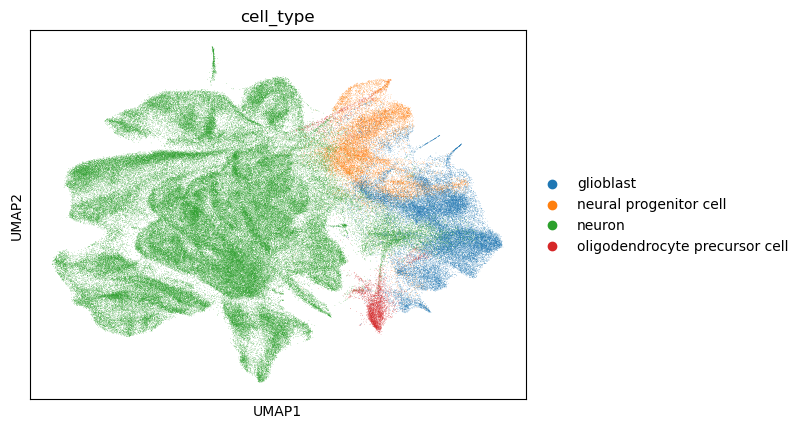

In [10]:
sc.pl.umap(ref, color = ['cell_type'], wspace = 0.5)

In [14]:

import pickle
with open('../public/fetal_pre_ingest.pkl', 'wb') as f:
    pickle.dump(ref, f)

In [15]:
sc.tl.ingest(adata, ref, obs='cell_type')

In [18]:
adata.write('../output/tumor_ingest.h5ad')

In [3]:
import scanpy as sc
import pickle
adata = sc.read_h5ad('../output/tumor_ingest.h5ad')
with open('../public/fetal_pre_ingest.pkl', 'rb') as f:
    ref = pickle.load(f)

In [7]:
full = sc.concat([adata, ref], label='source', keys = ['tumor', 'reference'])

In [8]:
with open('../public/fetal_pre_ingest_full.pkl', 'wb') as f:
    pickle.dump(full, f)

In [13]:
sc.pl.umap(full[~idx], color="cell_type", show=False, alpha=0.05)

<Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

<Figure size 1200x900 with 0 Axes>

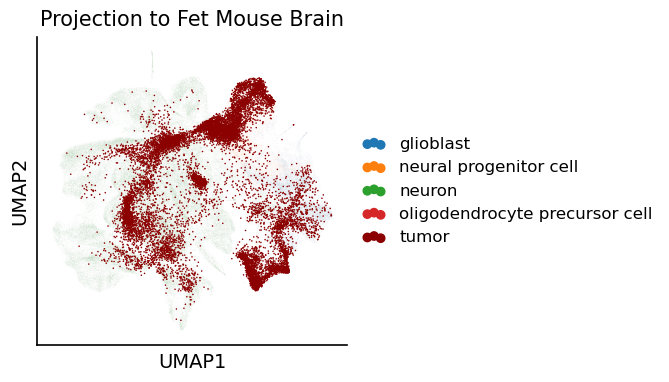

In [11]:
idx = full.obs.source == "tumor"
with mplscience.style_context():
    plt.figure(figsize=(12, 9))
    # First plot non-query cells with original colors but low alpha
    ax = sc.pl.umap(full[~idx], color="cell_type", show=False, alpha=0.05)
    # Then overlay query cells in red
    sc.pl.umap(full[idx], color="source", ax=ax, s=5, palette=['darkred'], title = 'Projection to Fet Mouse Brain')

In [10]:
full.write('../public/fetal_ingested.h5ad')

# 2. Adult

In [3]:
ref = sc.read_h5ad('../public/allen_adult.h5ad')
ref = ref.raw.to_adata()
print(np.max(ref.X))
ref = ref[ref.obs['cell_type'] != 'cell'].copy()
ref.var['gene_id'] = ref.var_names
ref.var.index = ref.var['feature_name']
ref.var

3304.0


,n_cells,feature_name,feature_reference,feature_biotype,feature_length,gene_id
feature_name,,,,,,
Xkr4,168904,Xkr4,NCBITaxon:10090,gene,6094,ENSMUSG00000051951
Rp1,1178,Rp1,NCBITaxon:10090,gene,12311,ENSMUSG00000025900
Sox17,617,Sox17,NCBITaxon:10090,gene,4772,ENSMUSG00000025902
Mrpl15,42451,Mrpl15,NCBITaxon:10090,gene,8487,ENSMUSG00000033845
Lypla1,54285,Lypla1,NCBITaxon:10090,gene,7145,ENSMUSG00000025903
...,...,...,...,...,...,...
Uty,183,Uty,NCBITaxon:10090,gene,9791,ENSMUSG00000068457
Ddx3y,16,Ddx3y,NCBITaxon:10090,gene,5199,ENSMUSG00000069045
Usp9y,1255,Usp9y,NCBITaxon:10090,gene,8094,ENSMUSG00000069044


In [4]:
mapper = {
    "inhibitory interneuron": "neuron",
    "medium spiny neuron": "neuron",
    "neuron": "neuron",
    "astrocyte": "astrocyte",
    "oligodendrocyte": "oligodendrocyte",
    "oligodendrocyte precursor cell": "oligodendrocyte precursor cell"
}

ref = ref[ref.obs['cell_type'].isin(['astrocyte', 'oligodendrocyte',
       'inhibitory interneuron', 'neuron',
       'oligodendrocyte precursor cell', 'medium spiny neuron'
       ])].copy()

ref.obs['cell_type'] = ref.obs['cell_type'].map(mapper).fillna(ref.obs['cell_type'])

In [5]:
keep_genes = adata.var_names.intersection(ref.var_names)
adata = adata[:, keep_genes].copy()
ref = ref[:, keep_genes].copy()

In [6]:
ref.layers['counts'] = ref.X.copy()
sc.pp.normalize_total(ref)
sc.pp.log1p(ref)

In [7]:
sc.pp.highly_variable_genes(ref, n_top_genes = 2000)
sc.pp.scale(ref)
sc.pp.pca(ref)
sc.pp.neighbors(ref)
sc.tl.umap(ref)

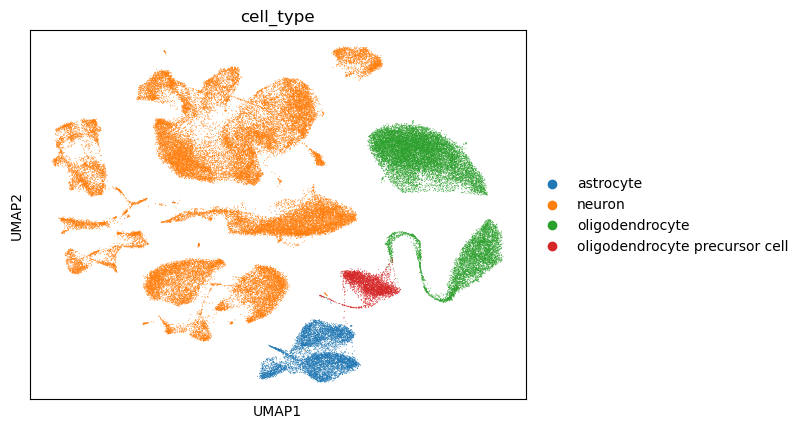

In [8]:
sc.pl.umap(ref, color = ['cell_type'], wspace = 0.5)

In [9]:
gc.collect()
sc.tl.ingest(adata, ref, obs='cell_type')

In [10]:
gc.collect()
full = sc.concat([adata, ref], label='source', keys = ['tumor', 'reference'])

<Figure size 1200x900 with 0 Axes>

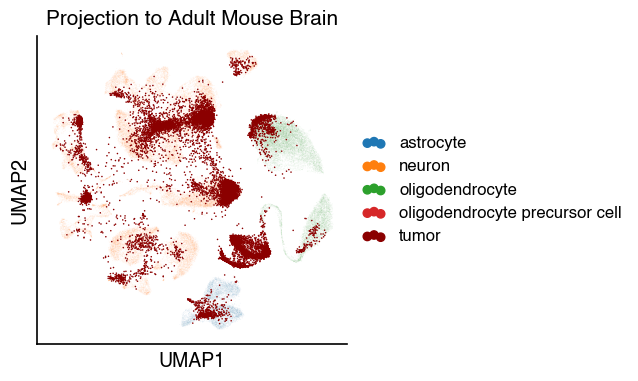

In [16]:
idx = full.obs.source == "tumor"
with mplscience.style_context():
    plt.figure(figsize=(12, 9))
    # First plot non-query cells with original colors but low alpha
    ax = sc.pl.umap(full[~idx], color="cell_type", show=False, alpha=0.05)
    # Then overlay query cells in red
    sc.pl.umap(full[idx], color="source", ax=ax, s=5, palette=['darkred'], title = 'Projection to Adult Mouse Brain')

# 3. Concat

In [177]:
ref = sc.concat([ref1, ref2], label = 'source', keys = ['fetal', 'adult'])

In [4]:
keep_genes = adata.var_names.intersection(ref.var_names)
adata = adata[:, keep_genes].copy()
ref = ref[:, keep_genes].copy()

NameError: name 'ref' is not defined

In [ ]:
ref.layers['counts'] = ref.X.copy()
sc.pp.normalize_total(ref)
sc.pp.log1p(ref)

In [181]:
sc.pp.highly_variable_genes(ref, n_top_genes = 2000, batch_key = 'source')
sc.pp.scale(ref)
sc.pp.pca(ref)
sc.pp.neighbors(ref)
sc.tl.umap(ref)

In [153]:
# sce.pp.harmony_integrate(ref, 'source')
# sc.pp.neighbors(ref, use_rep = "X_pca_harmony")
# sc.tl.umap(ref)

2025-01-03 17:19:31,596 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-03 17:19:38,385 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-03 17:19:38,839 - harmonypy - INFO - Iteration 1 of 10
2025-01-03 17:20:16,848 - harmonypy - INFO - Iteration 2 of 10
2025-01-03 17:20:54,535 - harmonypy - INFO - Iteration 3 of 10
2025-01-03 17:21:32,697 - harmonypy - INFO - Converged after 3 iterations


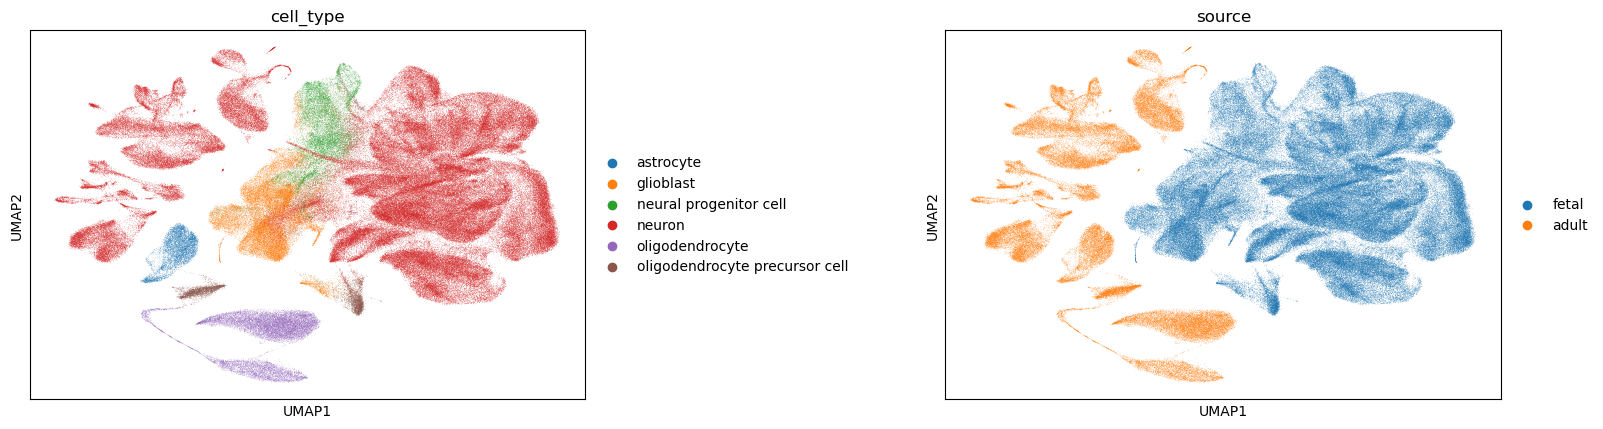

In [ ]:
sc.pl.umap(ref, color = ['cell_type', 'source'], wspace = 0.5)

In [184]:
adata.obs['source'] = 'tumor'

In [ ]:
sc.tl.ingest(adata, ref, obs='cell_type')

In [186]:
full = sc.concat([adata, ref])

: 

<Figure size 1200x900 with 0 Axes>

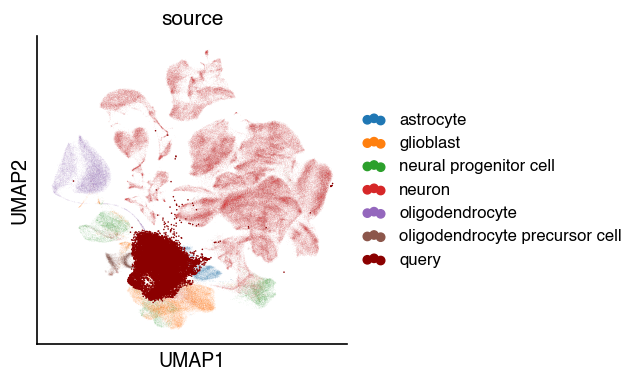

In [ ]:
idx = full.obs.source == "query"
with mplscience.style_context():
    plt.figure(figsize=(12, 9))
    # First plot non-query cells with original colors but low alpha
    ax = sc.pl.umap(full[~idx], color="cell_type", show=False, alpha=0.2)
    # Then overlay query cells in red
    sc.pl.umap(full[idx], color="source", ax=ax, s=5, palette=['darkred'])

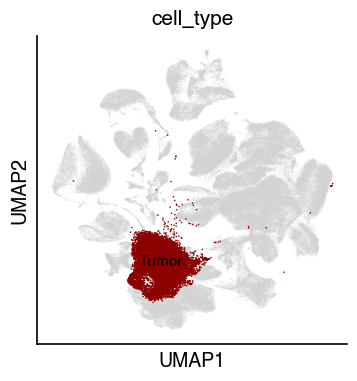

In [150]:
idx = full.obs.source == "query"
with mplscience.style_context():
    ax = sc.pl.umap(full, palette = 'lightgrey', show = False)
    sc.pl.umap(full[idx], color = "cell_type", ax = ax, s=5, palette= ['darkred'], legend_loc = 'on data', )


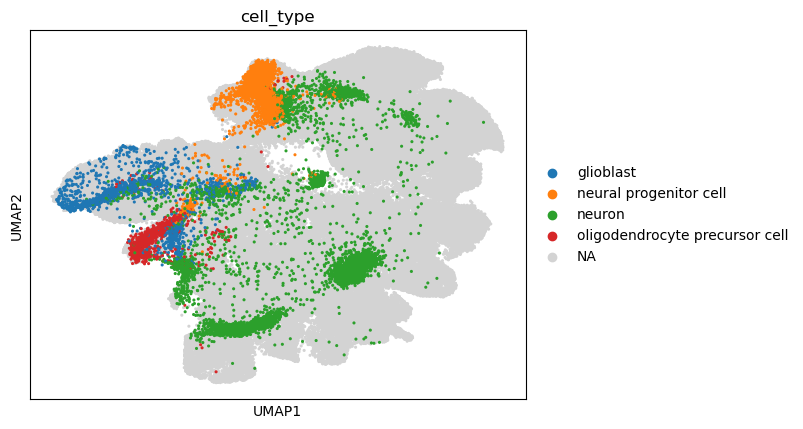

In [43]:
sc.pl.umap(full, color="cell_type", mask_obs=(full.obs.source == "query"), size=20)
